In [1]:
import os
# os.environ['MUSDB_PATH'] = '/root/MUSDB18/MUSDB18-7' # <- change to local dataset path

import sys
sys.path.append(os.path.abspath('../'))

In [2]:
import musdb

mus_train = musdb.DB(subsets="train", split='train')
mus_valid = musdb.DB(subsets="train", split='valid')

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from torchmetrics.functional import signal_distortion_ratio
from torchinfo import summary
import musdb, museval
import torch
import transforms
import utils
from mdensenet import MDenseNet
from datasets import STFTDataset, SamplingTrackDataset, FullTrackDataset
from tqdm.notebook import tqdm

torch.cuda.device_count()

1

In [4]:
seed = 42

torch.manual_seed(seed)
rng = np.random.default_rng(seed)

train_size, valid_size = 86, 14
sample_length_seconds = 5
sample_length_seconds_valid = 15
batch_size = 8
valid_batch_size = 8

training_data = SamplingTrackDataset(mus_train.tracks[:train_size], seconds=sample_length_seconds, target='vocals', rng=rng)
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

valid_data = FullTrackDataset(mus_valid.tracks[:valid_size], seconds=sample_length_seconds_valid, target='vocals')
valid_loader = DataLoader(valid_data, batch_size=valid_batch_size)

In [5]:
in_channels, num_features = 2, 32

growth_rate = [12,12,12,12,12,12,12]
# growth_rate = [10,10,10,10,10,10,10]
kernel_size = 3

dilated = [True] * len(growth_rate)
norm = [True] * len(growth_rate)
nonlinear = [True] * len(growth_rate)
depth = [4,4,4,4,4,4,4]
# depth = [3,3,3,3,3,3,3]

growth_rate_final=4
kernel_size_final=3
depth_final=2
dilated_final=True
norm_final=True
nonlinear_final=True

model = MDenseNet(in_channels, num_features, growth_rate, kernel_size, dilated=dilated, norm=norm, nonlinear=nonlinear, depth=depth,
    growth_rate_final=growth_rate_final, kernel_size_final=kernel_size_final, depth_final=depth_final,
    dilated_final=dilated_final, norm_final=norm_final, nonlinear_final=nonlinear_final)
model.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

summary(model)


Layer (type:depth-idx)                                       Param #
MDenseNet                                                    --
├─MDenseNetBackbone: 1-1                                     --
│    └─Conv2d: 2-1                                           608
│    └─Encoder: 2-2                                          --
│    │    └─Sequential: 3-1                                  48,208
│    └─DenseBlock: 2-3                                       --
│    │    └─Sequential: 3-2                                  13,176
│    └─Decoder: 2-4                                          --
│    │    └─Sequential: 3-3                                  56,988
├─ReLU: 1-2                                                  --
├─DenseBlock: 1-3                                            --
│    └─Sequential: 2-5                                       --
│    │    └─ConvBlock2d: 3-4                                 896
│    │    └─ConvBlock2d: 3-5                                 156
├─BatchNorm2d: 1-4  

In [6]:
epochs = 150
train_losses, valid_losses = [], []

for epoch in tqdm(range(epochs)):

    model.train()
    train_loss = []
    for i, (mixture, target) in enumerate(train_loader):

        optimizer.zero_grad()
        # magnitude, phase = torch.abs(mixture), torch.angle(mixture)
        # outputs = model(magnitude) * torch.exp(1j * phase)
        outputs = model(torch.abs(mixture))

        loss = loss_fn(outputs, torch.abs(target))
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
    
    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)

    if epoch == 0 or (epoch + 1) % 10 == 0:
        model.eval()
        valid_loss = []
        with torch.no_grad():
            for i, (mixture, target) in enumerate(valid_loader):

                outputs = model(torch.abs(mixture))

                loss = loss_fn(outputs, torch.abs(target))
                valid_loss.append(loss.item())

        valid_loss = np.mean(valid_loss)
        valid_losses.append(valid_loss)
    
    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f'epoch {epoch}: train loss {train_loss:3f} valid loss {valid_loss:3f}')
    else:
        print(f'epoch {epoch}: train loss {train_loss:3f}')

    if (epoch + 1) % 20 == 0:
        model_path = os.path.join('../../models/mdensenet', f'trained_model_epoch_{epoch+1}.pt')
        torch.save(model.state_dict(), model_path)

    del outputs, loss

  0%|          | 0/150 [00:00<?, ?it/s]

epoch 0: train loss 5.686284 valid loss 4.683269
epoch 1: train loss 4.787401
epoch 2: train loss 4.618042
epoch 3: train loss 3.853819
epoch 4: train loss 4.002542
epoch 5: train loss 4.043412
epoch 6: train loss 4.155167
epoch 7: train loss 3.851567
epoch 8: train loss 3.324923
epoch 9: train loss 3.164906 valid loss 2.667902
epoch 10: train loss 2.877707
epoch 11: train loss 3.031786
epoch 12: train loss 2.806187
epoch 13: train loss 3.057892
epoch 14: train loss 2.633925
epoch 15: train loss 2.850652
epoch 16: train loss 2.590496
epoch 17: train loss 2.384865
epoch 18: train loss 2.748695
epoch 19: train loss 2.560249 valid loss 2.228445
epoch 20: train loss 2.460679
epoch 21: train loss 1.942459
epoch 22: train loss 2.277836
epoch 23: train loss 1.860004
epoch 24: train loss 2.300148
epoch 25: train loss 1.979652
epoch 26: train loss 2.263143
epoch 27: train loss 1.858058
epoch 28: train loss 2.217773
epoch 29: train loss 1.529848 valid loss 1.764004
epoch 30: train loss 2.056621


In [7]:
model_path = os.path.join('../../models/mdensenet', f'trained_model_epoch_{epochs}.pt')
torch.save(model.cpu().state_dict(), model_path)
torch.save(model.get_config(), os.path.join('../../models/mdensenet', f'model_config.pt'))
print(f'Done, model saved at {model_path}')

Done, model saved at ../../models/mdensenet/trained_model_epoch_150.pt


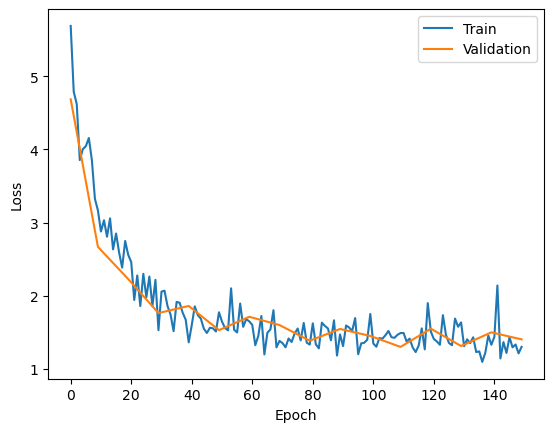

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train')
plt.plot([0,9,19,29,39,49,59,69,79,89,99,109,119,129,139,149], valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [9]:
import scipy.io.wavfile

model.cuda()
model.eval()
sdrs = []
preds, targets = [], []
with torch.no_grad():
    for i, track in tqdm(enumerate(mus_valid.tracks)):
        print(i, track)
        mixture_track, target_track, pred_track = [], [], []
        for (mixture_audio, target_audio) in utils.slice_musdb_track_iterator(track, 60., sample_targets='vocals'):
            mixture = transforms.stft(torch.tensor(mixture_audio[None], dtype=torch.float))
            output = model(torch.abs(mixture)) * torch.exp(1j * torch.angle(mixture))
            pred_audio = transforms.istft(output, device='cpu')[0]
            pred_track.append(pred_audio)
            mixture_track.append(torch.tensor(mixture_audio[:,:pred_audio.size(-1)], device='cpu'))
            target_track.append(torch.tensor(target_audio[:,:pred_audio.size(-1)], device='cpu'))

        mixture_track = torch.cat(mixture_track, dim=1).numpy().T
        target_track = torch.cat(target_track, dim=1).numpy().T
        pred_track = torch.cat(pred_track, dim=1).numpy().T

        sdr, _, _, _ = museval.metrics.bss_eval_sources([target_track], [pred_track], compute_permutation=False)
        print(sdr[0][0])
        sdrs.append(sdr)

        # sdr = signal_distortion_ratio(
        #     pred_track,
        #     target_track).cpu().numpy().flatten()

        # scipy.io.wavfile.write(f'../audio_outputs/preds/{i}.wav', 44100, pred_track)
        # scipy.io.wavfile.write(f'../audio_outputs/mixtures/{i}.wav', 44100, mixture_track)
        # scipy.io.wavfile.write(f'../audio_outputs/targets/{i}.wav', 44100, target_track)

        # del pred_track, mixture_track, target_track

print(np.mean(sdrs))

0it [00:00, ?it/s]

0 ANiMAL - Rockshow
0.46385739491934297
1 Actions - One Minute Smile
3.9302542602301305
2 Alexander Ross - Goodbye Bolero
2.5357086938508977
3 Clara Berry And Wooldog - Waltz For My Victims
2.878596636981551
4 Fergessen - Nos Palpitants
9.734619868162888
5 James May - On The Line
6.029529024815546
6 Johnny Lokke - Promises & Lies
4.134228981607655
7 Leaf - Summerghost
5.641434579677897
8 Meaxic - Take A Step
4.375668102722941
9 Patrick Talbot - A Reason To Leave
6.946761327009377
10 Skelpolu - Human Mistakes
-0.10792481616882192
11 Traffic Experiment - Sirens
-0.5594182523104079
12 Triviul - Angelsaint
5.416527350878935
13 Young Griffo - Pennies
4.220786457916255
3.9743306864495844


In [13]:
mus_test = musdb.DB(subsets="test")

model.cuda()
model.eval()
sdrs = []
preds, targets = [], []
with torch.no_grad():
    for i in tqdm(range(len(mus_test.tracks))):
        track = mus_test.tracks[i]
        print(i, track)
        mixture_track, target_track, pred_track = [], [], []
        for (mixture_audio, target_audio) in utils.slice_musdb_track_iterator(track, 60., sample_targets='vocals'):
            mixture = transforms.stft(torch.tensor(mixture_audio[None], dtype=torch.float))
            output = model(torch.abs(mixture)) * torch.exp(1j * torch.angle(mixture))
            pred_audio = transforms.istft(output, device='cpu')[0]
            pred_track.append(pred_audio)
            mixture_track.append(torch.tensor(mixture_audio[:,:pred_audio.size(-1)], device='cpu'))
            target_track.append(torch.tensor(target_audio[:,:pred_audio.size(-1)], device='cpu'))

        mixture_track = torch.cat(mixture_track, dim=1).numpy().T
        target_track = torch.cat(target_track, dim=1).numpy().T
        pred_track = torch.cat(pred_track, dim=1).numpy().T

        sdr, _, _, _ = museval.metrics.bss_eval_sources([target_track], [pred_track], compute_permutation=False)
        print(sdr[0][0])
        sdrs.append(sdr[0][0])

        # scipy.io.wavfile.write(f'../test_audio/mdensenet/pred/{i}.wav', 44100, pred_track)
        # scipy.io.wavfile.write(f'../test_audio/mdensenet/target/{i}.wav', 44100, target_track)
        # scipy.io.wavfile.write(f'../test_audio/mdensenet/mixture/{i}.wav', 44100, mixture_track)

        del pred_track, mixture_track, target_track

sdr = np.mean(sdrs)
print('final sdr', sdr)

  0%|          | 0/50 [00:00<?, ?it/s]

0 AM Contra - Heart Peripheral
6.50906439311332
1 Al James - Schoolboy Facination
3.6986156844787677
2 Angels In Amplifiers - I'm Alright
4.489620816917347
3 Arise - Run Run Run
1.5003358080156037
4 BKS - Bulldozer
0.015386695508459397
5 BKS - Too Much
6.136540527499975
6 Ben Carrigan - We'll Talk About It All Tonight
1.8729145323049816
7 Bobby Nobody - Stitch Up
2.889819678227922
8 Buitraker - Revo X
-0.361498160566927
9 Carlos Gonzalez - A Place For Us
3.7237640140311874
10 Cristina Vane - So Easy
6.225130299855434
11 Detsky Sad - Walkie Talkie
-0.6479034300237168
12 Enda Reilly - Cur An Long Ag Seol
6.269134198159753
13 Forkupines - Semantics
2.1968176525849925
14 Georgia Wonder - Siren
1.319266693007701
15 Girls Under Glass - We Feel Alright
1.4655401500000897
16 Hollow Ground - Ill Fate
-1.0434686909086808
17 James Elder & Mark M Thompson - The English Actor
4.5280140546403205
18 Juliet's Rescue - Heartbeats
5.028507005946572
19 Little Chicago's Finest - My Own
4.953961522150553
2

In [14]:
np.median(sdrs)

3.5532865293801246